In [36]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time


import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [37]:
print(os.getcwd())

C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums


In [38]:
# Declare important variables
train_path = 'train.csv'
solve_path = 'test.csv'
target_variable = 'Premium Amount'
SEED = 69

In [39]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    if socket.gethostname() == 'zchodani-p-l01':
        file_directory = r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    elif socket.gethostname() == 'FTILC3VBil7BwCe':
        file_directory = r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    else:
        file_directory = r"C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
         
    os.chdir(file_directory)

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    return df1, df2

In [40]:
df_train, df_solve = load_dataframes(train_path,solve_path)

In [41]:
df_train_id = df_train['id']
df_train = df_train.drop('id',axis=1)

df_solve_id = df_solve['id']
df_solve = df_solve.drop('id',axis=1)

In [42]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [43]:
# Smoothed distributions of X values
#plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [44]:
# Smoothed distributions of X values for real data
#plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

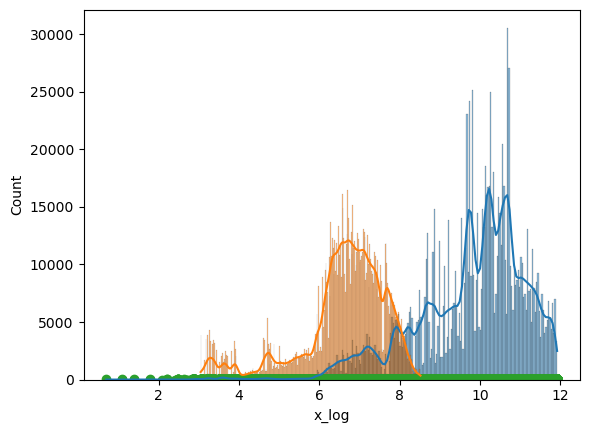

In [45]:
""" Annual Income and Premium Amount look to have some sort of correlation
    and both are right skew, lets look close
"""
df_hist = pd.DataFrame()
df_hist['x_log'] = np.log(df_train['Annual Income'] + 1)   # Add 1 to avoid log(0)
df_hist['y_log'] = np.log(df_train['Premium Amount'] + 1)  # Add 1 to avoid log(0)

# Plot histograms to check for skewness
sns.histplot(df_hist['x_log'], kde=True)
sns.histplot(df_hist['y_log'], kde=True)

# Scatter plot to check correlation between x and y
plt.scatter(df_hist['x_log'], df_hist['y_log'])
plt.show()

In [46]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
    # Plot unique values
    fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
    ax.set_title(f'{name} Unique Values')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

In [47]:
def clean_dataframe(df_to_use: pd.DataFrame) -> None:
    df = df_to_use.copy()
    
    # inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    # df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})  
    # # Merge the two DataFrames on 'column'
    # inf['missing'] = df_missing['missing'] 
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=[np.float64, np.int64, np.int32]).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

     # Fill nulls in numeric columns with the median
    for column in missing_numeric_columns:
        mdn = df[column].median()
        df[column] = df[column].fillna(mdn)

    
    # Get object columns
    object_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()  
    # Fill missing values in object columns
    for column in object_cols:
        df[column] = df[column].fillna('Unknown')
    
    return df, numeric_cols, object_cols

In [48]:
def transform_dataframe(df_to_use: pd.DataFrame) -> None:
    
    df = df_to_use.copy()
    
    # Transform Date Fields
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month Name'] = df['Policy Start Date'].dt.month_name()
    df['Day of Week'] = df['Policy Start Date'].dt.day_name()
    #df['Week'] = df['Policy Start Date'].dt.isocalendar().week.astype('int32')
    df['Year Sin'] = np.sin(2 * np.pi * df['Year'])
    #df['Year Cos'] = np.cos(2 * np.pi * df['Year'])
    df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day Sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day Cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    #df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df = df.drop('Policy Start Date', axis=1)
    
    
       # Creating Ratio variables, as well as categorizing continuous ones
    df['Claims v Duration'] = df['Previous Claims'] / df['Insurance Duration']
    df['Cat Credit Score'] = df['Credit Score'].copy()
    df['Int Credit Score'] = df['Credit Score'].apply(lambda x: int(x) if pd.notna(x) else x)
    df['Int Annual Income'] = df['Annual Income'].apply(lambda x: int(x) if pd.notna(x) else x)
    
    

    # List of columns to encode
    columns_to_encode = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
    ]
    
    # Apply frequency encoding to Categories
    for col in columns_to_encode:
        # Get the column names before encoding
        existing_columns = set(df.columns)
        
        freq_encoding = df[col].value_counts()  # Count occurrences
        # Do not need to encode columns with Cat_Boost
        #df[f'{col}_Freq'] = df[col].map(freq_encoding).astype('int32')  # Map frequencies to the original data
        
        
    #df = df.drop(columns=columns_to_encode, axis=1)
    
    return df

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,18705,1.558750,47,0,18.000000,64.000000,41.145563,13.539950,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,602571
2,Annual Income,float64,44949,3.745750,88593,0,1.000000,149997.000000,32745.217777,32179.506124,nan,nan
3,Marital Status,object,18529,1.544083,3,0,nan,nan,nan,nan,Single,395391
4,Number of Dependents,float64,109672,9.139333,5,0,0.000000,4.000000,2.009934,1.417338,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Master's,303818
6,Occupation,object,358075,29.839583,3,0,nan,nan,nan,nan,Employed,282750
7,Health Score,float64,74076,6.173000,532657,0,2.012237,58.975914,25.613908,12.203462,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,401542
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,401846


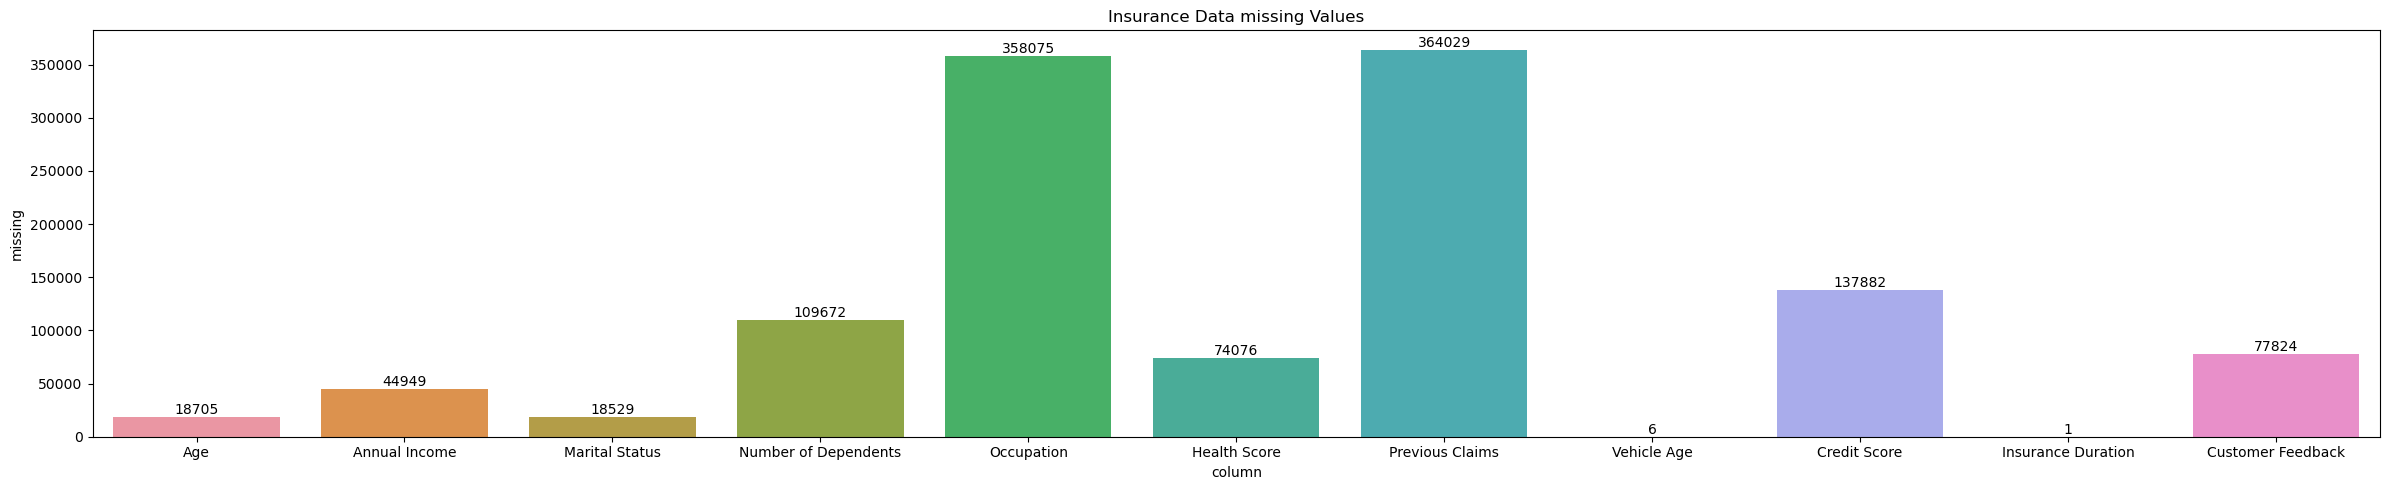

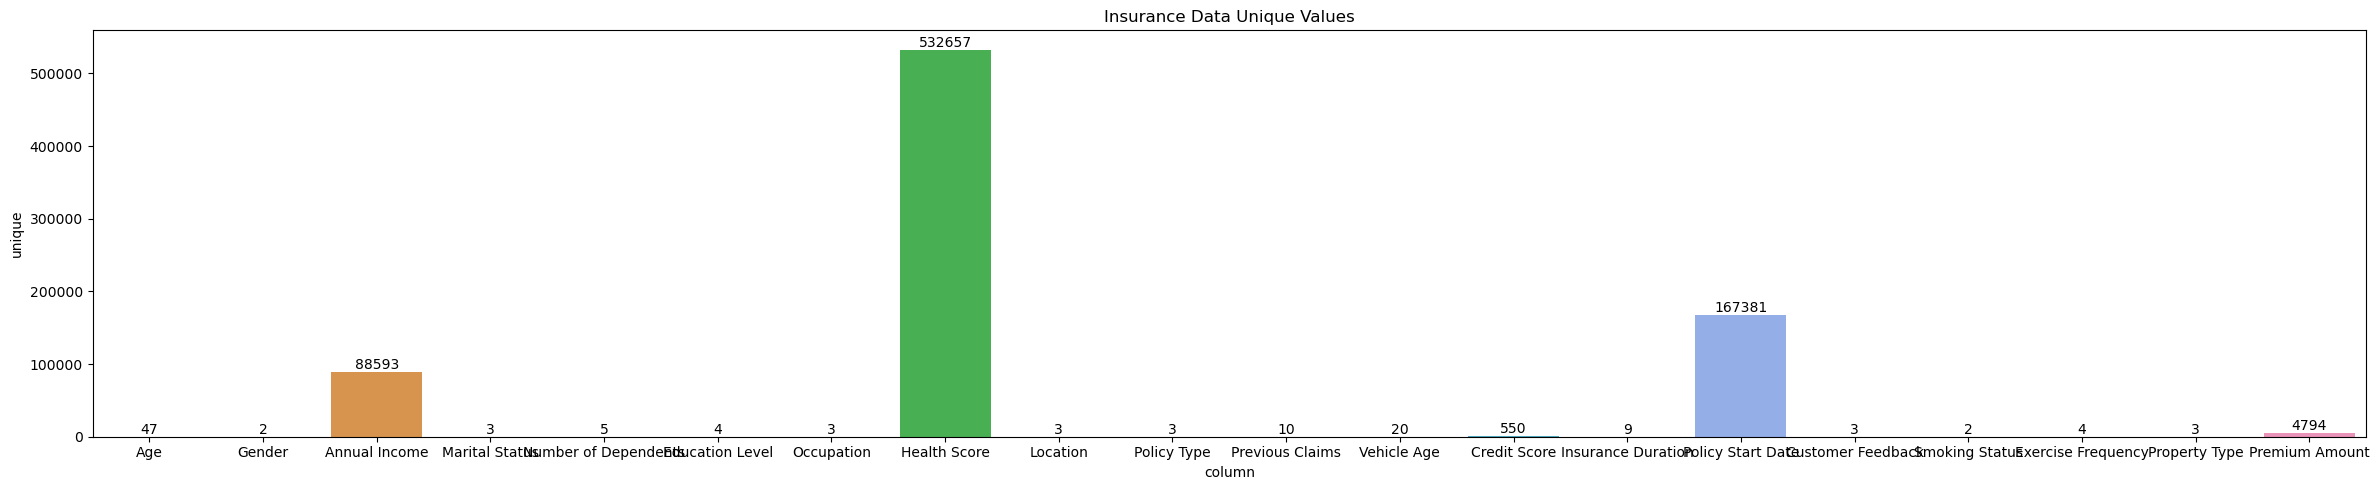

In [49]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=True, info=True)

In [50]:
df_train_cleaned, train_clean_num_cols, train_clean_object_cols = clean_dataframe(df_train)
df_solve_cleaned, solve_clean_num_cols, solve_clean_object_cols = clean_dataframe(df_solve)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.143294,13.434020,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,602571
2,Annual Income,float64,0,0.000000,88593,0,1.000000,149997.000000,32414.310064,31615.603456,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,395391
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.009026,1.351022,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Master's,303818
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,358075
7,Health Score,float64,0,0.000000,532658,0,2.012237,58.975914,25.550001,11.823428,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,401542
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,401846


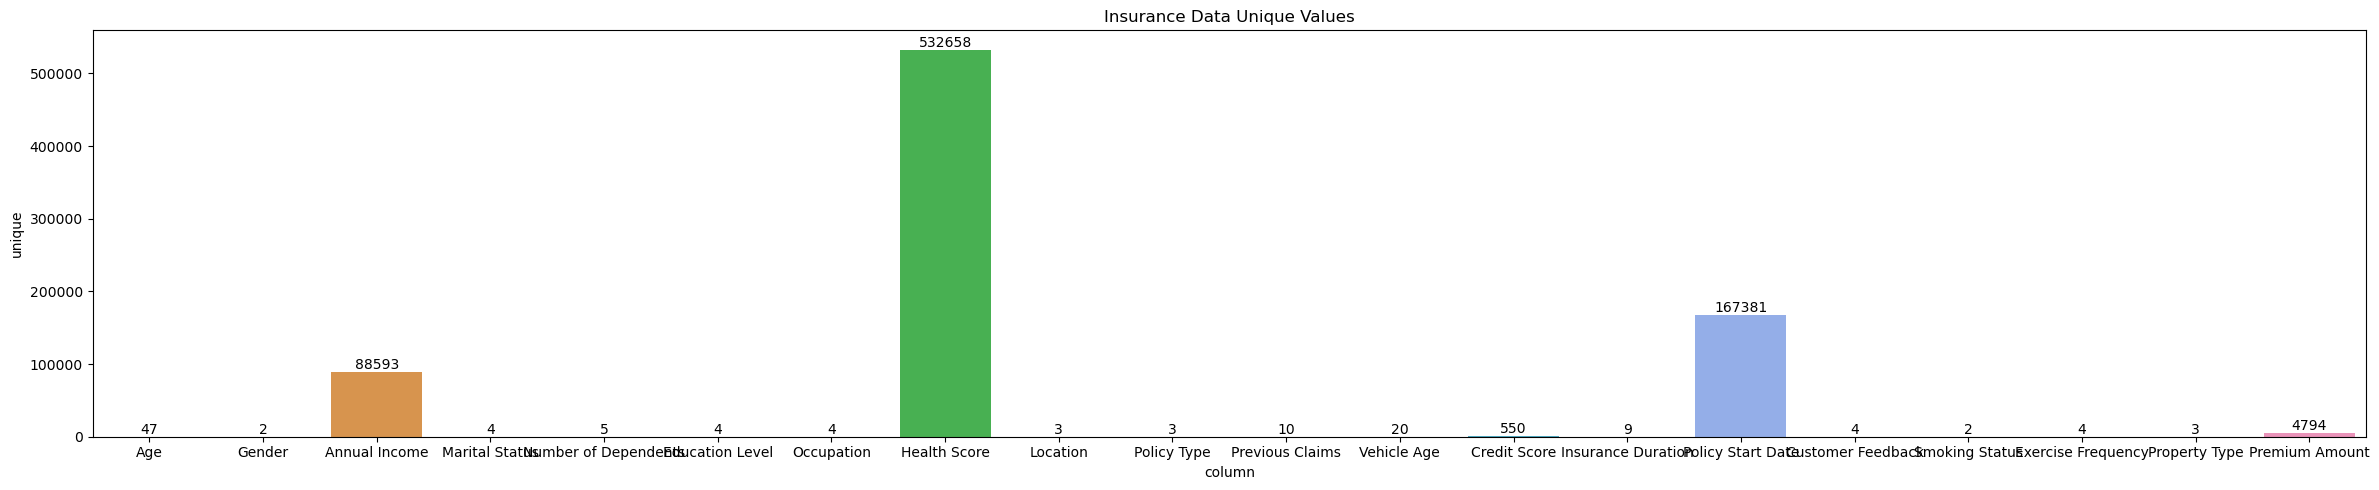

In [51]:
describe_dataframe(df_train_cleaned, name='Insurance Data', nrows=0, plots=True, info=True)

In [52]:
df_train_prepared = transform_dataframe(df_train_cleaned)
df_solve_prepared = transform_dataframe(df_solve_cleaned)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.143294,13.434020,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,602571
2,Annual Income,float64,0,0.000000,88593,0,1.000000,149997.000000,32414.310064,31615.603456,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,395391
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.009026,1.351022,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Master's,303818
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,358075
7,Health Score,float64,0,0.000000,532658,0,2.012237,58.975914,25.550001,11.823428,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,401542
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,401846


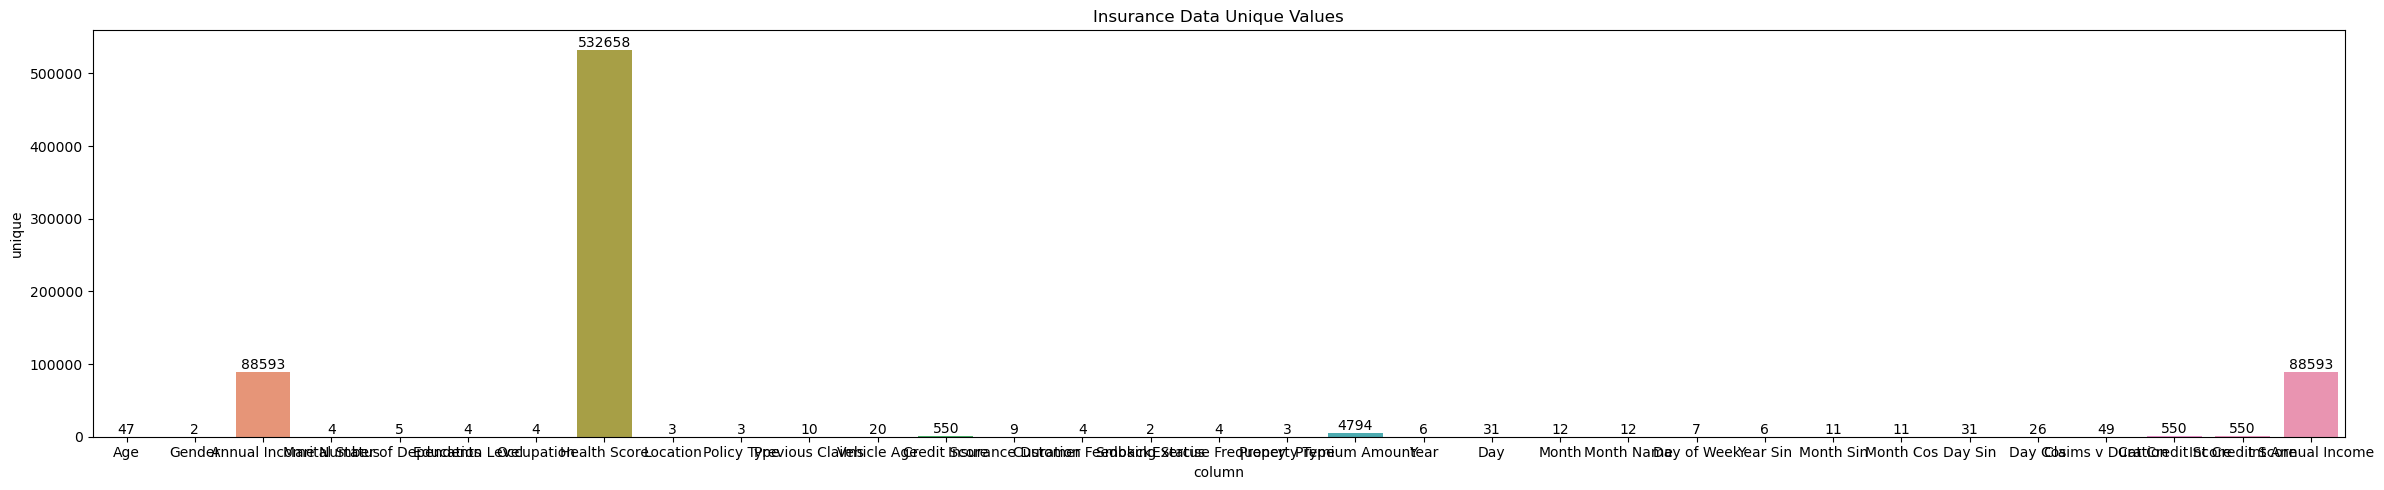

In [53]:
describe_dataframe(df_train_prepared, name='Insurance Data', nrows=0, plots=True, info=True)

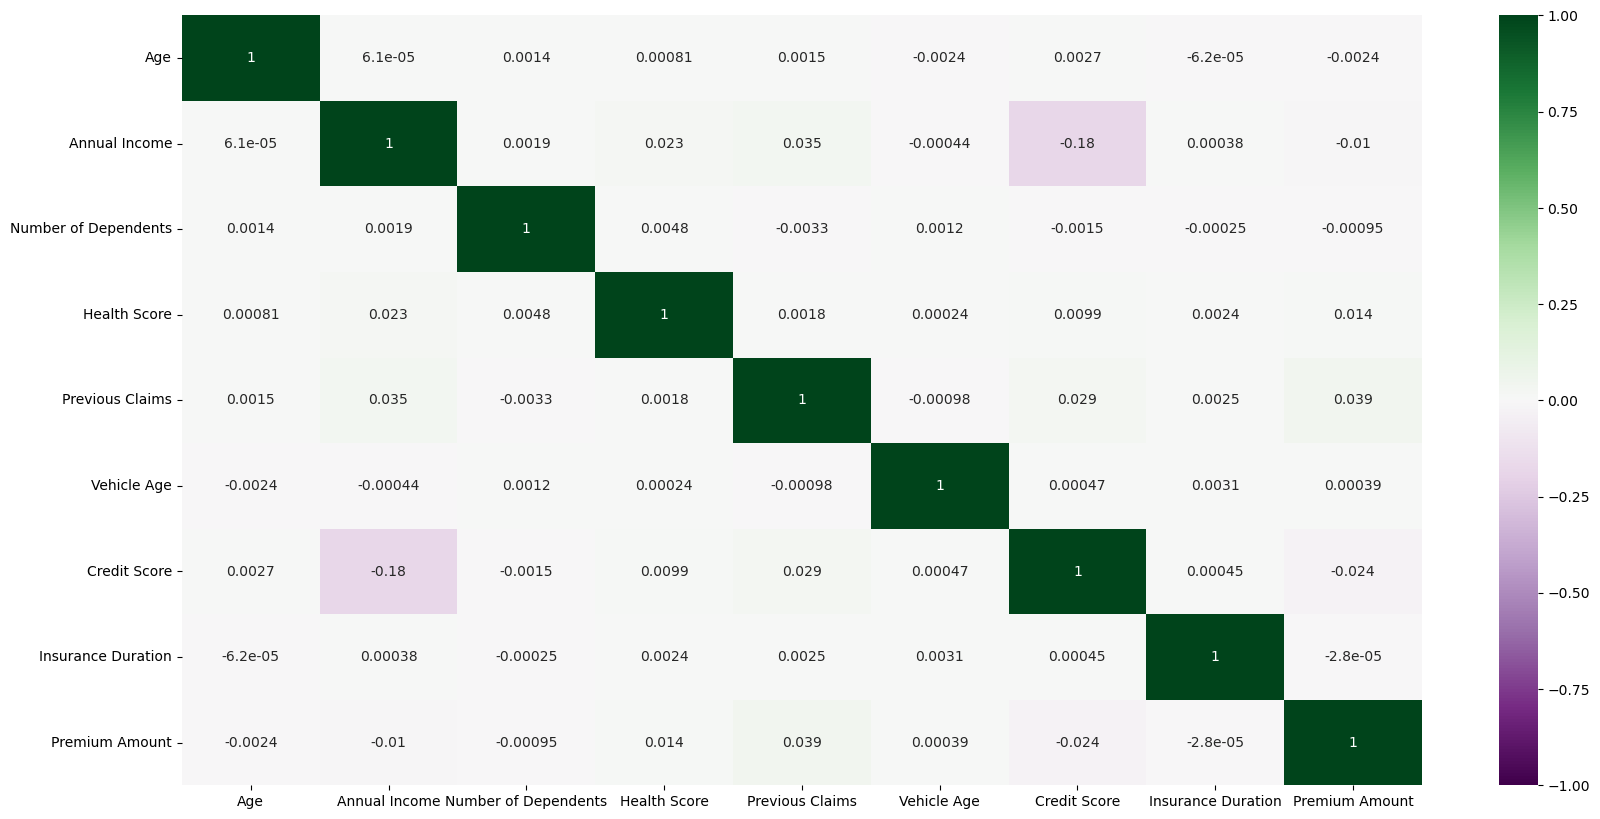

In [54]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train_prepared[train_clean_num_cols].corr(),
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            cmap='PRGn')
plt.show()

In [55]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train_prepared.drop('Premium Amount', axis=1)
y = df_train_prepared['Premium Amount'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


y_log_train = np.log1p(y_train)
y_log_test = np.log1p(y_test)

In [56]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_cols = X.select_dtypes(include=[np.float64, np.int64, np.int32]).columns
print(numeric_cols)

# Define a ColumnTransformer for scaling numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Fit and transform training data
X_train_prepared= pipeline.fit_transform(X_train)


# Transform validation and test data usingthe same pipeline
X_test_prepared= pipeline.transform(X_test)


# Extract the transformed column names
# Combine numeric column names (scaled) and other columns (passed through)
transformed_columns = numeric_cols.tolist() + [
    col for col in X_train.columns if col not in numeric_cols
]

# Convert the output to a DataFrame
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=transformed_columns)

# Transform validation and test data and convert them to DataFrames
X_test_prepared_df = pd.DataFrame(pipeline.transform(X_test), columns=transformed_columns)


Index(['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Year', 'Day', 'Month', 'Year Sin', 'Month Sin', 'Month Cos', 'Day Sin',
       'Day Cos', 'Claims v Duration', 'Cat Credit Score', 'Int Credit Score',
       'Int Annual Income'],
      dtype='object')


In [57]:
from keras import backend as K
from sklearn.metrics import mean_squared_log_error

#Define a custom RMSLE metric
def rmsle(y_true, y_pred):  
    # To avoid log(0), clip values to a small positive constant (epsilon)
    epsilon = tf.keras.backend.epsilon()

    # Apply log transformation
    #y_true_log = tf.math.log1p(y_true)  # Log-transform the true values
    #y_pred_log = tf.math.log1p(y_pred)  # Log-transform the clipped predicted values
    
    # RMSLE formula
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [58]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [60]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

# Parameter grid
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.1, 0.01],
    'depth': [5, 6, 7]
}


category_columns = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
        ]
category_indicies = [X.columns.get_loc(col) for col in category_columns]

# Leave some cores available
available_cores = os.cpu_count()
n_cores = max(1, available_cores - 4)  # Leave 2 cores free


cat_boost = CatBoostRegressor(random_state=SEED)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_boost,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Output progress messages
    n_jobs=n_cores
)

# Start the timer
start_time = time.time()

grid_search.fit(X_train_prepared_df, y_log_train,cat_features = category_columns)

# End the timer
end_time = time.time()

best_params = grid_search.best_params_
best_rmse = (-grid_search.best_score_)**0.5

print("Best parameters:",best_params)
print("Best RMSE:", best_rmse)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0:	learn: 1.0908962	total: 705ms	remaining: 5m 51s
1:	learn: 1.0864818	total: 1.42s	remaining: 5m 52s
2:	learn: 1.0828039	total: 2.12s	remaining: 5m 52s
3:	learn: 1.0796947	total: 2.79s	remaining: 5m 46s
4:	learn: 1.0772183	total: 3.41s	remaining: 5m 37s
5:	learn: 1.0749232	total: 4.07s	remaining: 5m 34s
6:	learn: 1.0732008	total: 4.73s	remaining: 5m 32s
7:	learn: 1.0718239	total: 5.45s	remaining: 5m 35s
8:	learn: 1.0705957	total: 6.18s	remaining: 5m 37s
9:	learn: 1.0691292	total: 6.87s	remaining: 5m 36s
10:	learn: 1.0682558	total: 7.6s	remaining: 5m 37s
11:	learn: 1.0657649	total: 8.36s	remaining: 5m 39s
12:	learn: 1.0637402	total: 9.09s	remaining: 5m 40s
13:	learn: 1.0628018	total: 9.94s	remaining: 5m 44s
14:	learn: 1.0618225	total: 10.6s	remaining: 5m 43s
15:	learn: 1.0612208	total: 11.4s	remaining: 5m 44s
16:	learn: 1.0598630	total: 12.2s	remaining: 5m 46s
17:	learn: 1.0592427	total: 12.9s	remaining: 5m 46s
18:	learn: 1.0

156:	learn: 1.0475463	total: 1m 46s	remaining: 3m 52s
157:	learn: 1.0474840	total: 1m 47s	remaining: 3m 51s
158:	learn: 1.0474278	total: 1m 47s	remaining: 3m 51s
159:	learn: 1.0474058	total: 1m 48s	remaining: 3m 50s
160:	learn: 1.0474053	total: 1m 49s	remaining: 3m 49s
161:	learn: 1.0474046	total: 1m 49s	remaining: 3m 48s
162:	learn: 1.0474045	total: 1m 50s	remaining: 3m 48s
163:	learn: 1.0473586	total: 1m 51s	remaining: 3m 48s
164:	learn: 1.0473331	total: 1m 52s	remaining: 3m 47s
165:	learn: 1.0473210	total: 1m 52s	remaining: 3m 47s
166:	learn: 1.0472868	total: 1m 53s	remaining: 3m 46s
167:	learn: 1.0472582	total: 1m 54s	remaining: 3m 46s
168:	learn: 1.0472394	total: 1m 55s	remaining: 3m 45s
169:	learn: 1.0472065	total: 1m 55s	remaining: 3m 44s
170:	learn: 1.0471886	total: 1m 56s	remaining: 3m 44s
171:	learn: 1.0471539	total: 1m 57s	remaining: 3m 43s
172:	learn: 1.0471312	total: 1m 57s	remaining: 3m 42s
173:	learn: 1.0471310	total: 1m 58s	remaining: 3m 41s
174:	learn: 1.0471182	total:

309:	learn: 1.0457663	total: 3m 25s	remaining: 2m 5s
310:	learn: 1.0457525	total: 3m 25s	remaining: 2m 5s
311:	learn: 1.0457485	total: 3m 26s	remaining: 2m 4s
312:	learn: 1.0457464	total: 3m 27s	remaining: 2m 3s
313:	learn: 1.0457346	total: 3m 27s	remaining: 2m 3s
314:	learn: 1.0457292	total: 3m 28s	remaining: 2m 2s
315:	learn: 1.0457083	total: 3m 29s	remaining: 2m 1s
316:	learn: 1.0456908	total: 3m 29s	remaining: 2m 1s
317:	learn: 1.0456852	total: 3m 30s	remaining: 2m
318:	learn: 1.0456795	total: 3m 30s	remaining: 1m 59s
319:	learn: 1.0456773	total: 3m 31s	remaining: 1m 59s
320:	learn: 1.0456710	total: 3m 32s	remaining: 1m 58s
321:	learn: 1.0456568	total: 3m 33s	remaining: 1m 57s
322:	learn: 1.0456429	total: 3m 33s	remaining: 1m 57s
323:	learn: 1.0456394	total: 3m 34s	remaining: 1m 56s
324:	learn: 1.0456393	total: 3m 35s	remaining: 1m 55s
325:	learn: 1.0456260	total: 3m 35s	remaining: 1m 55s
326:	learn: 1.0456201	total: 3m 36s	remaining: 1m 54s
327:	learn: 1.0456187	total: 3m 36s	rema

464:	learn: 1.0441544	total: 5m 5s	remaining: 23s
465:	learn: 1.0441520	total: 5m 6s	remaining: 22.3s
466:	learn: 1.0441509	total: 5m 6s	remaining: 21.7s
467:	learn: 1.0441093	total: 5m 7s	remaining: 21s
468:	learn: 1.0440937	total: 5m 8s	remaining: 20.4s
469:	learn: 1.0440769	total: 5m 8s	remaining: 19.7s
470:	learn: 1.0440745	total: 5m 9s	remaining: 19.1s
471:	learn: 1.0440594	total: 5m 10s	remaining: 18.4s
472:	learn: 1.0440528	total: 5m 10s	remaining: 17.7s
473:	learn: 1.0440510	total: 5m 11s	remaining: 17.1s
474:	learn: 1.0440460	total: 5m 12s	remaining: 16.4s
475:	learn: 1.0440426	total: 5m 12s	remaining: 15.8s
476:	learn: 1.0440283	total: 5m 13s	remaining: 15.1s
477:	learn: 1.0440111	total: 5m 14s	remaining: 14.5s
478:	learn: 1.0440005	total: 5m 14s	remaining: 13.8s
479:	learn: 1.0439947	total: 5m 15s	remaining: 13.1s
480:	learn: 1.0439867	total: 5m 16s	remaining: 12.5s
481:	learn: 1.0439727	total: 5m 16s	remaining: 11.8s
482:	learn: 1.0439570	total: 5m 17s	remaining: 11.2s
483:

In [61]:
# Calculate elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

Elapsed time: 142.27 minutes


In [62]:
print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)

Best parameters: {'depth': 7, 'iterations': 500, 'learning_rate': 0.1}
Best RMSE: 1.0482845368144484


In [63]:
# depth = 7   iterations = 500   learning rate = 0.1
# RMSE = 1.0482845368144484

In [64]:

# Initialize the CatBoost
cat_boost = CatBoostRegressor(
    **best_params,
    verbose=100,
    cat_features=category_columns,
    eval_metric='RMSE',
    random_state=SEED
)

# Train the model
cat_boost.fit(
    X_train_prepared_df, 
    y_log_train, 
    eval_set=[(X_test_prepared_df, y_log_test)]
)

0:	learn: 1.0908962	test: 1.0885197	best: 1.0885197 (0)	total: 786ms	remaining: 6m 32s
100:	learn: 1.0487133	test: 1.0462014	best: 1.0462014 (100)	total: 1m 10s	remaining: 4m 39s
200:	learn: 1.0469048	test: 1.0449312	best: 1.0449300 (195)	total: 2m 18s	remaining: 3m 26s
300:	learn: 1.0458532	test: 1.0446066	best: 1.0446007 (298)	total: 3m 27s	remaining: 2m 17s
400:	learn: 1.0447979	test: 1.0444061	best: 1.0443972 (392)	total: 4m 39s	remaining: 1m 8s
499:	learn: 1.0437556	test: 1.0442965	best: 1.0442965 (499)	total: 5m 50s	remaining: 0us

bestTest = 1.044296493
bestIteration = 499



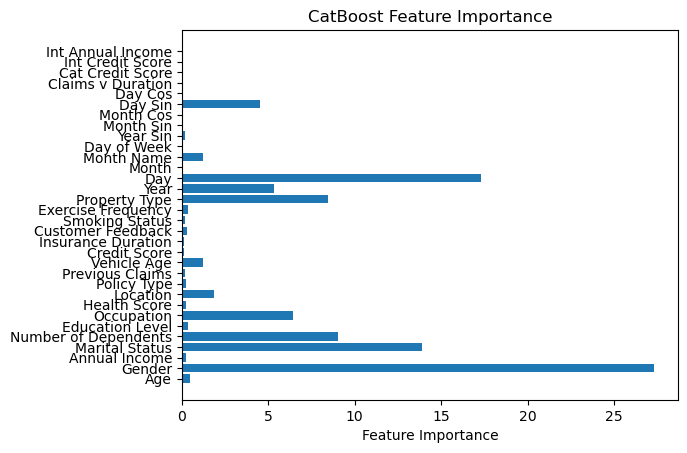

In [65]:
# Plot feature importance
import matplotlib.pyplot as plt

feature_importances = cat_boost.get_feature_importance()
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [66]:
# Predict on test set
y_test_pred = cat_boost.predict(X_test_prepared_df)

<Axes: >

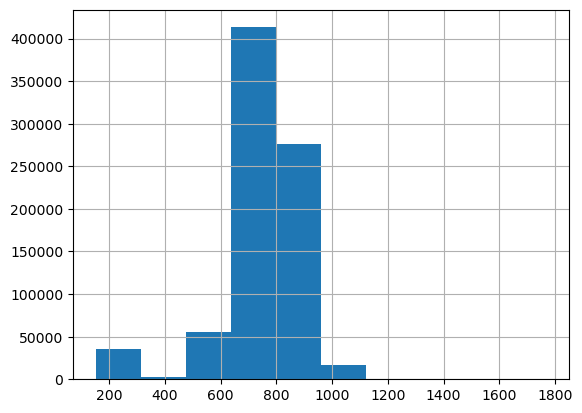

In [67]:
# Create final predictions
df_solve_cleaned, solve_cleaned_num_cols, solve_cleaned_cat_cols = clean_dataframe(df_solve)
df_solve_prepared = transform_dataframe(df_solve_cleaned)
X_solve_prepared= pipeline.transform(df_solve_prepared)


y_log_solve = cat_boost.predict(X_solve_prepared)

y_solve = np.expm1(y_log_solve)  # Inverse of log1p (to get the original scale)

df_y_solve = pd.DataFrame(y_solve, columns=['Premium Amount'])
df_final = pd.merge(df_solve_id, df_y_solve, left_index=True, right_index=True, how='inner')
df_final.to_csv('Predictions.csv', index=False)

df_final['Premium Amount'].hist()